In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.cnn import cnn_4layer
from model.mlp import mlp_layer

2024-01-12 12:47:19.426980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 12:47:19.537229: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 12:47:19.973042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64::/lclhome/jshi008/miniconda3/envs/flood/lib/:/lclhome/jshi008/miniconda3/envs/flood/lib/python3.9/site-packages/nvidia/cudnn/lib:/lclhome/jshi008/miniconda3/envs/flood/lib/:/lclhome/jshi008/minic

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import random

random.seed(10)
print(random.random())

0.5714025946899135


In [5]:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/#climate-data-timeseries
data = pd.read_csv("../../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [6]:
data.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')

In [7]:
# plt.hist(data['pollution'], bins=20)

### Preprocess

In [8]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (43717, 924)


In [9]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 792) (30601, 12) (6558, 792) (6558, 12) (6558, 792) (6558, 12)


In [10]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 72, 11) (30601, 12) (6558, 72, 11) (6558, 12) (6558, 72, 11) (6558, 12)


### PM threshold

In [11]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(30601,)
(6558,)
(6558,)


In [12]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.33400402414486924


### train_X_filter

In [13]:
train_X_extreme = train_X[train_X_pm > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_y[train_X_pm > percentile_pm]
print(train_y_extreme.shape)

(848, 72, 11)
(848, 12)


In [14]:
train_X_normal = train_X[train_X_pm <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_y[train_X_pm <= percentile_pm]
print(train_y_normal.shape)

(29753, 72, 11)
(29753, 12)


### val_X_filter

In [15]:
val_X_extreme = val_X[val_X_pm > percentile_pm]
print(val_X_extreme.shape)

val_y_extreme = val_y[val_X_pm > percentile_pm]
print(val_y_extreme.shape)

(752, 72, 11)
(752, 12)


In [16]:
val_X_normal = val_X[val_X_pm <= percentile_pm]
print(val_X_normal.shape)

val_y_normal = val_y[val_X_pm <= percentile_pm]
print(val_y_normal.shape)

(5806, 72, 11)
(5806, 12)


### test_X_filter

In [17]:
test_X_extreme = test_X[test_X_pm > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_y[test_X_pm > percentile_pm]
print(test_y_extreme.shape)

(581, 72, 11)
(581, 12)


In [18]:
test_X_normal = test_X[test_X_pm <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_y[test_X_pm <= percentile_pm]
print(test_y_normal.shape)

(5977, 72, 11)
(5977, 12)


In [117]:
# Load your dataset
D_f, y_f = train_X, train_y                # Training data (includes both X_rain and X_norm)
# D_g, y_g = val_X_extreme, val_y_extreme   

D_g, y_g = np.concatenate((val_X_extreme, test_X_extreme)), np.concatenate((val_y_extreme, test_y_extreme))

In [118]:
D_f.shape

(30601, 72, 11)

### Model

In [151]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [152]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

In [153]:
# Define the forward function for the model
def forward(model, X, y, weights):
    predictions = model(X, training=True)
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y, predictions) * weights)
    return loss, predictions


def backward(loss):
    # Compute gradients of loss with respect to model parameters
    gradients = tf.gradients(loss, model.trainable_variables)
    return gradients



# Assuming model, D_f, y_f, example_weights, etc. are defined

# Define the loss function
def calculate_loss(model, X, y, weights):
    predictions = model(X)
    individual_losses = tf.losses.mean_squared_error(y, predictions)  # This gives a loss per sample
    weighted_losses = individual_losses * weights
    return tf.reduce_mean(weighted_losses), individual_losses

In [154]:
# # Define the optimizer for the primary model
# optimizer = Adam(learning_rate=0.01)

# Initialize the example weights wi with ones
# sample_weights_IPF = tf.ones(shape=(len(D_f)))

sample_weights_IPF = np.load('sample_weights_pm_IPF.npy')
example_weights = tf.convert_to_tensor(sample_weights_IPF, dtype=tf.float32)


# Batch size
batch_size = 128

In [155]:
# Training loop
for t in range(100):  # Number of iterations
    # Shuffle the training data and example weights at the beginning of each epoch
    indices = np.arange(len(D_f))
    #np.random.shuffle(indices)
    D_f_shuffled = tf.gather(D_f, indices)
    y_f_shuffled = tf.gather(y_f, indices)

    
    example_weights_shuffled = tf.gather(example_weights, indices)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])
    
    
    # Convert example_weights_shuffled back to a tf.Variable if it's not one after tf.gather
    example_weights_shuffled = tf.Variable(example_weights_shuffled)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])

    
    # Iterate over mini-batches
    for i in range(0, len(D_f), batch_size):
        # Slice the mini-batch
        X_batch = D_f_shuffled[i:i+batch_size]
        y_batch = y_f_shuffled[i:i+batch_size]
        w_batch = example_weights_shuffled[i:i+batch_size]

        # Forward pass on the training data with example weights
        with tf.GradientTape() as tape:
            train_loss_f, _ = forward(model, X_batch, y_batch, w_batch)
        gradients_f = tape.gradient(train_loss_f, model.trainable_variables)

        # Apply gradients to update the model parameters
        model.optimizer.apply_gradients(zip(gradients_f, model.trainable_variables))

        
    # After processing all mini-batches, evaluate on validation set
    val_loss_g, val_predictions_g = forward(model, D_g, y_g, tf.ones(shape=(len(D_g), 1)))

    
    # Meta-learning step: Compute the influence of training example weights on validation loss
    with tf.GradientTape() as tape:
        # Re-compute training loss for shuffled data with current model parameters and example weights
        tape.watch(example_weights_shuffled)
        train_loss_f, _ = forward(model, D_f_shuffled, y_f_shuffled, example_weights_shuffled)

        
    # Now compute gradients of this loss w.r.t. the example weights
    example_weight_gradients = tape.gradient(train_loss_f, example_weights_shuffled)
    
    
    # Adjust example weights based on gradients: This is a simplistic approach; actual update rule may differ
    example_weight_updates = -0.01 * example_weight_gradients
    
    
    # Apply updates to the example weights
    example_weights_shuffled.assign_add(example_weight_updates)
    
    # Ensure example_weights remain non-negative and re-normalize
    example_weights_shuffled.assign(tf.maximum(example_weights_shuffled, 0))
    example_weights_shuffled.assign(example_weights_shuffled / tf.reduce_sum(example_weights_shuffled))
    
    
    # Update the original example weights
    indices_matrix = tf.reshape(indices, (len(indices), 1)) 
    example_weights = tf.tensor_scatter_nd_update(example_weights, indices_matrix, example_weights_shuffled)
    #print("example_weights:", example_weights[:3])
    

    # Log the progress
    print(f'Epoch {t+1}: Training Loss = {train_loss_f.numpy():.6f}, Validation Loss = {val_loss_g.numpy():.6f} \n')

Epoch 1: Training Loss = 0.000247, Validation Loss = 0.032151 

Epoch 2: Training Loss = 0.000000, Validation Loss = 0.026120 

Epoch 3: Training Loss = 0.000000, Validation Loss = 0.027426 

Epoch 4: Training Loss = 0.000000, Validation Loss = 0.027954 

Epoch 5: Training Loss = 0.000000, Validation Loss = 0.027952 

Epoch 6: Training Loss = 0.000000, Validation Loss = 0.027742 

Epoch 7: Training Loss = 0.000000, Validation Loss = 0.027381 

Epoch 8: Training Loss = 0.000000, Validation Loss = 0.026813 

Epoch 9: Training Loss = 0.000000, Validation Loss = 0.026089 

Epoch 10: Training Loss = 0.000000, Validation Loss = 0.025314 

Epoch 11: Training Loss = 0.000000, Validation Loss = 0.024380 

Epoch 12: Training Loss = 0.000000, Validation Loss = 0.023244 

Epoch 13: Training Loss = 0.000000, Validation Loss = 0.022051 

Epoch 14: Training Loss = 0.000000, Validation Loss = 0.020903 

Epoch 15: Training Loss = 0.000000, Validation Loss = 0.019819 

Epoch 16: Training Loss = 0.000000

In [156]:
example_weights = example_weights.numpy()

In [157]:
# example_weights /= np.max(example_weights) 
# example_weights = (example_weights - np.min(example_weights)) / (np.max(example_weights) - np.min(example_weights)) + 0.1

(array([2.857e+04, 1.596e+03, 2.200e+02, 1.180e+02, 5.400e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 1.700e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 1.200e+01,
        0.000e+00, 9.000e+00]),
 array([6.54403902e-06, 6.70979425e-05, 1.27651845e-04, 1.88205740e-04,
        2.48759636e-04, 3.09313560e-04, 3.69867455e-04, 4.30421351e-04,
        4.90975275e-04, 5.51529170e-04, 6.12083066e-04, 6.72636961e-04,
        7.33190856e-04, 7.93744752e-04, 8.54298647e-04, 9.14852542e-04,
        9.75406496e-04, 1.03596039e-03, 1.09651429e-03, 1.15706818e-03,
        1.21762208e-03]),
 <BarContainer object of 20 artists>)

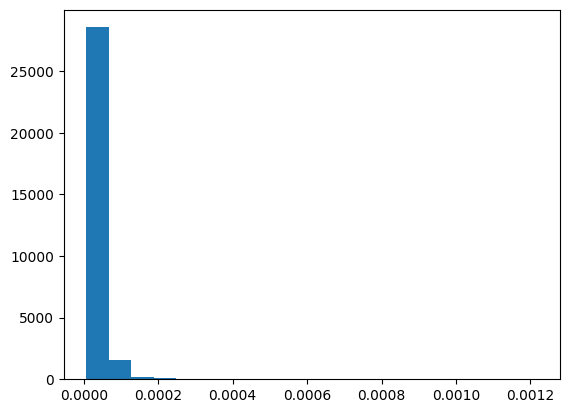

In [158]:
plt.hist(example_weights, bins=20)

In [159]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/pm_all_weighted_META.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=example_weights,
         )

Epoch 1/1000

Epoch 1: val_mae improved from inf to 0.05969, saving model to ../../saved_models/pm_all_weighted_META.h5
60/60 - 1s - loss: 1.1068e-04 - mae: 0.0408 - val_loss: 0.0080 - val_mae: 0.0597 - 1s/epoch - 17ms/step
Epoch 2/1000

Epoch 2: val_mae improved from 0.05969 to 0.05734, saving model to ../../saved_models/pm_all_weighted_META.h5
60/60 - 0s - loss: 1.0786e-04 - mae: 0.0402 - val_loss: 0.0078 - val_mae: 0.0573 - 355ms/epoch - 6ms/step
Epoch 3/1000

Epoch 3: val_mae did not improve from 0.05734
60/60 - 0s - loss: 1.0622e-04 - mae: 0.0405 - val_loss: 0.0084 - val_mae: 0.0597 - 333ms/epoch - 6ms/step
Epoch 4/1000

Epoch 4: val_mae did not improve from 0.05734
60/60 - 0s - loss: 1.0490e-04 - mae: 0.0402 - val_loss: 0.0080 - val_mae: 0.0577 - 331ms/epoch - 6ms/step
Epoch 5/1000

Epoch 5: val_mae did not improve from 0.05734
60/60 - 0s - loss: 1.0330e-04 - mae: 0.0402 - val_loss: 0.0080 - val_mae: 0.0583 - 330ms/epoch - 5ms/step
Epoch 6/1000

Epoch 6: val_mae did not improve f

60/60 - 0s - loss: 6.7349e-05 - mae: 0.0356 - val_loss: 0.0094 - val_mae: 0.0645 - 331ms/epoch - 6ms/step
Epoch 50/1000

Epoch 50: val_mae did not improve from 0.05734
60/60 - 0s - loss: 6.5539e-05 - mae: 0.0352 - val_loss: 0.0096 - val_mae: 0.0653 - 330ms/epoch - 6ms/step
Epoch 51/1000

Epoch 51: val_mae did not improve from 0.05734
60/60 - 0s - loss: 6.5537e-05 - mae: 0.0354 - val_loss: 0.0101 - val_mae: 0.0666 - 330ms/epoch - 5ms/step
Epoch 52/1000

Epoch 52: val_mae did not improve from 0.05734
60/60 - 0s - loss: 6.5507e-05 - mae: 0.0355 - val_loss: 0.0097 - val_mae: 0.0647 - 329ms/epoch - 5ms/step
Epoch 53/1000

Epoch 53: val_mae did not improve from 0.05734
60/60 - 0s - loss: 6.5748e-05 - mae: 0.0354 - val_loss: 0.0100 - val_mae: 0.0668 - 331ms/epoch - 6ms/step
Epoch 54/1000

Epoch 54: val_mae did not improve from 0.05734
60/60 - 0s - loss: 6.6937e-05 - mae: 0.0356 - val_loss: 0.0099 - val_mae: 0.0659 - 331ms/epoch - 6ms/step
Epoch 55/1000

Epoch 55: val_mae did not improve from 

60/60 - 0s - loss: 4.1606e-05 - mae: 0.0296 - val_loss: 0.0144 - val_mae: 0.0795 - 335ms/epoch - 6ms/step
Epoch 99/1000

Epoch 99: val_mae did not improve from 0.05734
60/60 - 0s - loss: 4.3267e-05 - mae: 0.0300 - val_loss: 0.0139 - val_mae: 0.0781 - 336ms/epoch - 6ms/step
Epoch 100/1000

Epoch 100: val_mae did not improve from 0.05734
60/60 - 0s - loss: 4.1811e-05 - mae: 0.0296 - val_loss: 0.0147 - val_mae: 0.0795 - 337ms/epoch - 6ms/step
Epoch 101/1000

Epoch 101: val_mae did not improve from 0.05734
60/60 - 0s - loss: 4.1467e-05 - mae: 0.0295 - val_loss: 0.0150 - val_mae: 0.0810 - 336ms/epoch - 6ms/step
Epoch 102/1000

Epoch 102: val_mae did not improve from 0.05734
60/60 - 0s - loss: 4.1209e-05 - mae: 0.0294 - val_loss: 0.0151 - val_mae: 0.0807 - 335ms/epoch - 6ms/step
Epoch 103/1000

Epoch 103: val_mae did not improve from 0.05734
60/60 - 0s - loss: 4.2196e-05 - mae: 0.0297 - val_loss: 0.0144 - val_mae: 0.0787 - 335ms/epoch - 6ms/step
Epoch 104/1000

Epoch 104: val_mae did not imp

Epoch 147/1000

Epoch 147: val_mae did not improve from 0.05734
60/60 - 0s - loss: 3.0324e-05 - mae: 0.0254 - val_loss: 0.0197 - val_mae: 0.0922 - 331ms/epoch - 6ms/step
Epoch 148/1000

Epoch 148: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.9145e-05 - mae: 0.0248 - val_loss: 0.0209 - val_mae: 0.0938 - 331ms/epoch - 6ms/step
Epoch 149/1000

Epoch 149: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.9297e-05 - mae: 0.0249 - val_loss: 0.0203 - val_mae: 0.0933 - 332ms/epoch - 6ms/step
Epoch 150/1000

Epoch 150: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.9211e-05 - mae: 0.0247 - val_loss: 0.0191 - val_mae: 0.0918 - 329ms/epoch - 5ms/step
Epoch 151/1000

Epoch 151: val_mae did not improve from 0.05734
60/60 - 0s - loss: 3.2189e-05 - mae: 0.0260 - val_loss: 0.0198 - val_mae: 0.0922 - 332ms/epoch - 6ms/step
Epoch 152/1000

Epoch 152: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.9250e-05 - mae: 0.0247 - val_loss: 0.0191 - val_mae: 0.0914 - 330

60/60 - 0s - loss: 2.2671e-05 - mae: 0.0218 - val_loss: 0.0222 - val_mae: 0.1000 - 334ms/epoch - 6ms/step
Epoch 196/1000

Epoch 196: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.3368e-05 - mae: 0.0221 - val_loss: 0.0213 - val_mae: 0.0986 - 334ms/epoch - 6ms/step
Epoch 197/1000

Epoch 197: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.3258e-05 - mae: 0.0222 - val_loss: 0.0232 - val_mae: 0.1021 - 334ms/epoch - 6ms/step
Epoch 198/1000

Epoch 198: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.3105e-05 - mae: 0.0220 - val_loss: 0.0222 - val_mae: 0.1006 - 334ms/epoch - 6ms/step
Epoch 199/1000

Epoch 199: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.3286e-05 - mae: 0.0220 - val_loss: 0.0232 - val_mae: 0.1016 - 336ms/epoch - 6ms/step
Epoch 200/1000

Epoch 200: val_mae did not improve from 0.05734
60/60 - 0s - loss: 2.3111e-05 - mae: 0.0219 - val_loss: 0.0231 - val_mae: 0.1024 - 332ms/epoch - 6ms/step
Epoch 201/1000

Epoch 201: val_mae did not i